In [10]:
import mne
import glob
import matplotlib.pyplot as plt
import numpy as np
mne.viz.set_browser_backend('qt')
%matplotlib qt

## Define parameters

In [2]:
conditions = ['distractor','target']

## Find data files

In [3]:
data_files = glob.glob('*_ave.fif')

In [4]:
data_files

['006_1_ave.fif', '009_1_ave.fif']

In [4]:
evokeds = {}

for idx, c in enumerate(conditions):
    evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]

evokeds

Reading /Users/lina_01/acar-q1k-pilot-seg/006_1_ave.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms (0.50 × distractor/disp/left/ddtl + 0.48 × distractor/disp/right/ddtr + 0.02 × DIN4/distractor/disp/right/ddtr)
        0 CTF compensation matrices available
        nave = 51 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.5, 0] s)
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms (0.70 × target/disp/left/dttl + 0.30 × target/disp/right/dttr)
        0 CTF compensation matrices available
        nave = 37 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.5, 0] s)
Reading /Users/lina_01/acar-q1k-pilot-seg/009_1_ave.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms (0.50 × distractor/dis

{'distractor': [<Evoked | '0.50 × distractor/disp/left/ddtl + 0.48 × distractor/disp/right/ddtr + 0.02 × DIN4/distractor/disp/right/ddtr' (average, N=51), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>,
  <Evoked | '0.50 × distractor/disp/left/ddtl + 0.50 × distractor/disp/right/ddtr' (average, N=49), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>],
 'target': [<Evoked | '0.70 × target/disp/left/dttl + 0.30 × target/disp/right/dttr' (average, N=37), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>,
  <Evoked | '0.51 × target/disp/left/dttl + 0.49 × target/disp/right/dttr' (average, N=49), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>]}

## Compare evoked waveforms

In [11]:
roi = ['E6']

color_dict = {'distractor':'blue', 'target':'red'}
linestyle_dict = {'distractor':'-', 'target':'--'}


mne.viz.plot_compare_evokeds(evokeds,
                             combine='mean',
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict,
                             title='distractor vs. target Waveforms'
                            )
plt.show()

combining channels using "mean"
combining channels using "mean"


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_12189/4212917214.py:7: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds,


 ## Differences

In [7]:
diff_waves = []
for i in range(len(data_files)):
    diff_waves.append(mne.combine_evoked([evokeds['distractor'][i], evokeds['target'][i]],
                                          weights=[1, -1]
                                         )
                     )

diff_waves

[<Evoked | '(0.50 × distractor/disp/left/ddtl + 0.48 × distractor/disp/right/ddtr + 0.02 × DIN4/distractor/disp/right/ddtr) - (0.70 × target/disp/left/dttl + 0.30 × target/disp/right/dttr)' (average, N=21.443181818181817), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>,
 <Evoked | '(0.50 × distractor/disp/left/ddtl + 0.50 × distractor/disp/right/ddtr) - (0.51 × target/disp/left/dttl + 0.49 × target/disp/right/dttr)' (average, N=24.500000000000004), -0.5 – 1 s, baseline -0.5 – 0 s, 129 ch, ~1.6 MB>]

In [8]:
contrast = 'distractor-target'
mne.viz.plot_compare_evokeds({contrast:diff_waves}, combine='mean',
                            legend=None,
                            picks=roi, show_sensors='upper right',
                            title=contrast
                            )
plt.show()

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_12189/3376906048.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds({contrast:diff_waves}, combine='mean',


combining channels using "mean"


## Scalp topographic map

Interpolating bad channels
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 6 sensors
Interpolating bad channels
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 109 sensor positions
Interpolating 20 sensors
Identifying common channels ...


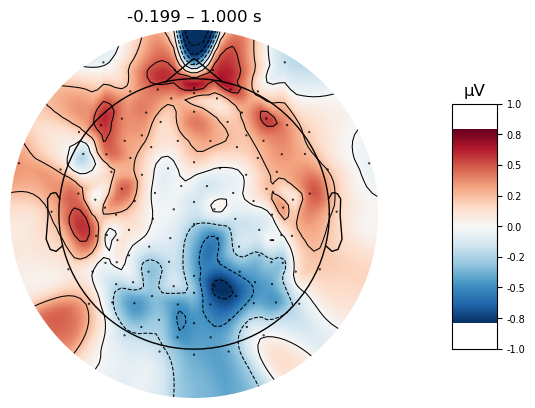

In [9]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=1.4,
                            size=3
                           )
plt.show()

## t-test

In [23]:
evoked_data = np.array([np.mean(e.get_data(picks='E6', tmin=-0.4, tmax=1.0), axis=1) for e in diff_waves])

In [24]:
from scipy import stats 

t, pval = stats.ttest_1samp(evoked_data, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  0.65 p =  0.6348


## permutation test

In [25]:
from mne.stats import permutation_t_test

In [26]:
evoked_data = np.array([np.mean(e.get_data(tmin=-0.4, tmax=1.0), axis=1) for e in diff_waves])

In [27]:
n_permutations = 50000
T0, p_values, H0 = permutation_t_test(evoked_data, n_permutations, tail=-1)

Permuting 3 times (exact test)...


In [30]:
p_values

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])